Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract ZIP file

In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Medical_Chatbot.zip'
extract_to = '/content/'

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("ZIP File Extraction completed")


ZIP File Extraction completed


In [ ]:
# These are built-in Python libraries for basic operations for medical chatbot
import os
import sys
import json
import zipfile
import shutil
import ast
import re
from pathlib import Path

# Core libraries for data manipulation
import pandas as pd
import numpy as np
import torch
import json

# NLTK toolkit for text preprocessing and linguistic analysis
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Hugging Face - transformers (BERT)
!pip install transformers
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
)

# Visualization tool for tracking loop progress
from tqdm import tqdm

Load CSV Files and Display Sample

In [ ]:
# Load the training data
train_df = pd.read_csv('/content/train_data_chatbot.csv')

print("TRAIN DATA SAMPLE")
display(train_df.head())

# Load the validation data
val_df = pd.read_csv('/content/validation_data_chatbot.csv')

print("VALIDATION DATA SAMPLE")
display(val_df.head())

TRAIN DATA SAMPLE


,short_question,short_answer,tags,label
0,can an antibiotic through an iv give you a ras...,yes it can even after you have finished the pr...,['rash' 'antibiotic'],1.0
1,can you test positive from having the hep b va...,test positive for what if you had a hep b vacc...,['hepatitis b'],1.0
2,what are the dietary restrictions for celiac d...,omitting gluten from the diet is the key to co...,['celiac disease'],1.0
3,can i transmit genital warts seventeen years a...,famotidine pepcid products is in a drug class ...,['wart'],-1.0
4,is all vitamin d the same,hi this means you do not have hepatitis b and ...,['vitamin d'],-1.0


VALIDATION DATA SAMPLE


,short_question,short_answer,tags,label
0,do i have a yeast infection,hi this can be a vaginal fungal infection whic...,['yeast infection'],1.0
1,does your upper backlung area hurt badly with ...,if you have a true allergy to sulfa medication...,['asthma' 'ibuprofen' 'lung' 'cough' 'inhaler'],-1.0
2,taken off paxil cold turk now on celexa having...,if overdose is suspected contact a poison cont...,['brain' 'lightheadedness' 'dizziness' 'coldne...,-1.0
3,i need to buy health insurance asap what do i ...,go to healthcare gov call my husband 407 222 9...,[''],1.0
4,what happens if a pregnant woman has genital h...,sorry for her pain i understand your feelings ...,['genital herpes' 'pregnancy'],-1.0


Combine/ Concatenate Multiple Files

In [ ]:
# Combine (concatenate) them
combined_df = pd.concat([train_df, val_df], ignore_index=True)

# Show the shape and preview
print("Datasets merged!")
print("Combined dataset shape:", combined_df.shape)
combined_df.head()

Datasets merged!
Combined dataset shape: (59504, 4)


,short_question,short_answer,tags,label
0,can an antibiotic through an iv give you a ras...,yes it can even after you have finished the pr...,['rash' 'antibiotic'],1.0
1,can you test positive from having the hep b va...,test positive for what if you had a hep b vacc...,['hepatitis b'],1.0
2,what are the dietary restrictions for celiac d...,omitting gluten from the diet is the key to co...,['celiac disease'],1.0
3,can i transmit genital warts seventeen years a...,famotidine pepcid products is in a drug class ...,['wart'],-1.0
4,is all vitamin d the same,hi this means you do not have hepatitis b and ...,['vitamin d'],-1.0


Check missing values and duplicates

In [ ]:
# Check for missing values
print("Missing values:")
print(combined_df.isnull().sum())

# Check for duplicate rows
print("\n Duplicate rows:", combined_df.duplicated().sum())

Missing values:
short_question    0
short_answer      0
tags              0
label             0
dtype: int64

 Duplicate rows: 8


Remove duplicates and reset index

In [ ]:
combined_df = combined_df.drop_duplicates().reset_index(drop=True)
print("After removing duplicates, shape:", combined_df.shape)

After removing duplicates, shape: (59496, 4)


Convert string representation of tags to lists

In [ ]:
# Convert tags column to actual lists on the full dataset
combined_df['tags'] = combined_df['tags'].apply(ast.literal_eval)

# Check first few rows
combined_df['tags'].head()

,tags
0,[rashantibiotic]
1,[hepatitis b]
2,[celiac disease]
3,[wart]
4,[vitamin d]


Gather all tags and compute unique tags/ Unique Diseases/Specializations

In [ ]:
# Flatten all tag lists and collect unique tags
all_tags = [tag.strip().lower() for tag_list in combined_df['tags'] for tag in tag_list]

# Convert to a set to get unique disease/symptom tags
unique_tags = set(all_tags)

# Show the total count and a few sample tags
print("Total unique disease/symptom tags:", len(unique_tags))
print("Sample tags:", list(unique_tags)[:20])

Total unique disease/symptom tags: 13390
Sample tags: ['', 'wrist painwristpainangerskin', 'eyesheadmorphinenauseadizziness', 'sore throatantibioticstrep throat', 'bowel movementconstipation', 'bowel movementgastroenteritiseyesinjectiondiarrhea', 'armhairaginghair loss', 'spots on both legs', 'drinkingurination', 'drinkingred wine', 'radiologist suggested there is caudal regression syndrome', 'depressionfibromyalgiapain', 'urinating problems', 'headacheeyeslipfeverswelling', 'sexual intercourseurethravagina', 'i was coughing up blood', 'painmuscle', 'high blood pressureblood pressuredietoliveoil', 'knee replacement', 'group a streptococcus bacteriascarlet fever']


 Simple text cleaning with regex

In [ ]:
def clean_text(text):
  # Convert to lowercase
    text = text.lower()

    # Remove line breaks and carriage returns
    text = re.sub(r'\n|\r', ' ', text)

    # Remove all non-alphabetic characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply to questions and answers
combined_df['question_clean'] = combined_df['short_question'].apply(clean_text)
combined_df['answer_clean'] = combined_df['short_answer'].apply(clean_text)

print("Sample cleaned Q&A:\n")
print(combined_df[['short_question', 'question_clean', 'short_answer', 'answer_clean']].head())


Sample cleaned Q&A:

                                      short_question  \
0  can an antibiotic through an iv give you a ras...   
1  can you test positive from having the hep b va...   
2  what are the dietary restrictions for celiac d...   
3  can i transmit genital warts seventeen years a...   
4                          is all vitamin d the same   

                                      question_clean  \
0  can an antibiotic through an iv give you a ras...   
1  can you test positive from having the hep b va...   
2  what are the dietary restrictions for celiac d...   
3  can i transmit genital warts seventeen years a...   
4                          is all vitamin d the same   

                                        short_answer  \
0  yes it can even after you have finished the pr...   
1  test positive for what if you had a hep b vacc...   
2  omitting gluten from the diet is the key to co...   
3  famotidine pepcid products is in a drug class ...   
4  hi this means you do n

NLTK downloads + lemmatization + stopwords removal

In [ ]:
# Import NLTK components
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary resources from NLTK
# 'wordnet' → used for lemmatization (dictionary of base words)
# 'omw-1.4' → multilingual wordnet data (dependency of lemmatizer)
# 'stopwords' → list of common English words to be removed
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize lemmatizer and stopword list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define normalization functio
def normalize_text(text):
# Split the sentence into individual words
    words = text.split()
# Remove stopwords and lemmatize each word
    normalized = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(normalized)

# Apply normalization to cleaned question and answe colums
combined_df['question_normalized'] = combined_df['question_clean'].apply(normalize_text)
combined_df['answer_normalized'] = combined_df['answer_clean'].apply(normalize_text)

# Show sample output for verification
print("Normalized text example:")
print(combined_df[['question_clean', 'question_normalized']].head(3))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Normalized text example:
                                      question_clean  \
0  can an antibiotic through an iv give you a ras...   
1  can you test positive from having the hep b va...   
2  what are the dietary restrictions for celiac d...   

                         question_normalized  
0   antibiotic iv give rash couple day later  
1                test positive hep b vaccine  
2  dietary restriction celiac disease gluten  


Save the Cleaned & Normalized Dataset

In [ ]:
# Save the cleaned and normalized dataset to a new CSV
combined_df.to_csv('/content/drive/MyDrive/cleaned_medical_chatbot.csv', index=False)

print("Cleaned data saved to cleaned_medical_chatbot.csv")


Cleaned data saved to cleaned_medical_chatbot.csv


Reload saved cleaned data (optional check)

In [ ]:
# Load the saved cleaned file from Google Drive
df_cleaned = pd.read_csv('/content/drive/MyDrive/cleaned_medical_chatbot.csv')
df_cleaned.head()

,short_question,short_answer,tags,label,question_clean,answer_clean,question_normalized,answer_normalized
0,can an antibiotic through an iv give you a ras...,yes it can even after you have finished the pr...,['rashantibiotic'],1.0,can an antibiotic through an iv give you a ras...,yes it can even after you have finished the pr...,antibiotic iv give rash couple day later,yes even finished prescription antibiotic
1,can you test positive from having the hep b va...,test positive for what if you had a hep b vacc...,['hepatitis b'],1.0,can you test positive from having the hep b va...,test positive for what if you had a hep b vacc...,test positive hep b vaccine,test positive hep b vaccine subsequent blood t...
2,what are the dietary restrictions for celiac d...,omitting gluten from the diet is the key to co...,['celiac disease'],1.0,what are the dietary restrictions for celiac d...,omitting gluten from the diet is the key to co...,dietary restriction celiac disease gluten,omitting gluten diet key controlling celiac di...
3,can i transmit genital warts seventeen years a...,famotidine pepcid products is in a drug class ...,['wart'],-1.0,can i transmit genital warts seventeen years a...,famotidine pepcid products is in a drug class ...,transmit genital wart seventeen year removed,famotidine pepcid product drug class called h ...
4,is all vitamin d the same,hi this means you do not have hepatitis b and ...,['vitamin d'],-1.0,is all vitamin d the same,hi this means you do not have hepatitis b and ...,vitamin,hi mean hepatitis b immune hepatitis b recomme...


Count unique normalized questions

In [ ]:
unique_cleaned_q_count = combined_df['question_normalized'].nunique()
print(f"Total unique normalized questions: {unique_cleaned_q_count}")

#To see some of the unique questions:
print(combined_df['question_normalized'].drop_duplicates().head(10))

Total unique normalized questions: 23186
0             antibiotic iv give rash couple day later
1                          test positive hep b vaccine
2            dietary restriction celiac disease gluten
3         transmit genital wart seventeen year removed
4                                              vitamin
5    disabled veteran medicare affected affordable ...
6    taking multiple antibiotic cause redness dryne...
7                 stroke brain cant get hour sleep day
8    pneumonia shot get either sinus infection walk...
9    ekg say moderate right axis deviation normal s...
Name: question_normalized, dtype: object


Count unique normalized answers

In [ ]:
# Count unique normalized answers
unique_cleaned_ans_count = combined_df['answer_normalized'].nunique()
print(f"Total unique normalized answers: {unique_cleaned_ans_count}")

#View Some of Them:
print(combined_df['answer_normalized'].drop_duplicates().head(10))

Total unique normalized answers: 29321
0            yes even finished prescription antibiotic
1    test positive hep b vaccine subsequent blood t...
2    omitting gluten diet key controlling celiac di...
3    famotidine pepcid product drug class called h ...
4    hi mean hepatitis b immune hepatitis b recomme...
5    risk developing epilepsy increase family histo...
6    fun question glad asked first let set mind eas...
7    generally healthy chance developing serious at...
8    always catch illness child viral like cold pne...
9    reason may feel stressed probably longer happy...
Name: answer_normalized, dtype: object


Imports for modeling

In [ ]:
import pandas as pd
import numpy as np
import torch
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve
import ast

Load cleaned data and basic filtering

In [ ]:
# Load cleaned dataset
data = pd.read_csv("/content/drive/MyDrive/cleaned_medical_chatbot.csv")

# Ensure tags are lists
data['tags'] = data['tags'].apply(ast.literal_eval)

# Use the normalized question column
data['question'] = data['question_normalized']

# Drop missing or empty values
data = data.dropna(subset=['question', 'tags'])
data = data[data['tags'].map(len) > 0].reset_index(drop=True)

Keep only the most frequent tags

In [ ]:
# Keep only top 200 most frequent tags
all_tags = [tag for tags_list in data['tags'] for tag in tags_list]
tag_counts = pd.Series(all_tags).value_counts()
top_tags = tag_counts.head(200).index.tolist()

def filter_top_tags(tags):
    return [tag for tag in tags if tag in top_tags]

data['tags'] = data['tags'].apply(filter_top_tags)
data = data[data['tags'].map(len) > 0].reset_index(drop=True)

Multi-hot encoding and train/test split

In [ ]:
# Encode labels into multi-hot vectors
mlb = MultiLabelBinarizer(classes=top_tags)
labels = mlb.fit_transform(data['tags'])

# Save label mapping
with open("/content/drive/MyDrive/label_map_top50.json", "w") as f:
    json.dump(mlb.classes_.tolist(), f)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['question'].tolist(),
    labels,
    test_size=0.2,
    random_state=42
)

Print dataset sizes

In [ ]:
#Display split statistics
# Total samples
total_samples = len(data)

# Train and test samples counts
train_count = len(train_texts)
test_count = len(test_texts)

# Percentages
train_percent = (train_count / total_samples) * 100
test_percent = (test_count / total_samples) * 100

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_count} ({train_percent:.2f}%)")
print(f"Test samples: {test_count} ({test_percent:.2f}%)")

Total samples: 17954
Training samples: 14363 (80.00%)
Test samples: 3591 (20.00%)


Tokenization with BERT tokenizer

In [ ]:
# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)
    encodings['labels'] = labels
    return encodings

train_encodings = tokenize(train_texts, train_labels)
test_encodings = tokenize(test_texts, test_labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Create a PyTorch Dataset wrapper

In [ ]:
# Dataset class
class ChatbotDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'labels'}
        item['labels'] = torch.tensor(self.encodings['labels'][idx], dtype=torch.float)
        return item

train_dataset = ChatbotDataset(train_encodings)
test_dataset = ChatbotDataset(test_encodings)

Compute class weights for balancing positive examples

In [ ]:
# Compute class weights for BCE loss (Binary Cross-Entropy.It’s a loss function used
#for binary classification tasks, and "class weights" are applied to balance the loss
#contribution from positive and negative classes when the dataset is imbalanced.)
# To emphasize rare classes, weight inversely proportional to frequency
pos_counts = train_labels.sum(axis=0)
neg_counts = train_labels.shape[0] - pos_counts
class_weights = neg_counts / (pos_counts + 1e-5)
class_weights = torch.tensor(class_weights, dtype=torch.float)

Custom model to apply weighted BCE loss

In [ ]:
# Custom model class to apply class weights in loss
from transformers import BertForSequenceClassification

class BertForMultiLabelWeightedLoss(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        self.loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None, num_items_in_batch=None, **kwargs):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=labels, **kwargs)
        logits = outputs.logits

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels.float()) # Ensure labels are float type

        return (loss, logits) if loss is not None else logits

Load config and instantiate the model with the custom class

In [ ]:
# Load model with class weights
from transformers import AutoConfig
config = AutoConfig.from_pretrained('bert-base-uncased', problem_type="multi_label_classification", num_labels=len(mlb.classes_))
model = BertForMultiLabelWeightedLoss.from_pretrained('bert-base-uncased', config=config, class_weights=class_weights)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultiLabelWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.pos_weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compute metrics and threshold tuning during evaluation

In [ ]:
# Threshold tuning inside compute_metrics for real-time evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).cpu().numpy()

    # Tune threshold by maximizing F1 score
    thresholds = np.linspace(0, 1, 50)
    f1_scores = []
    for thresh in thresholds:
        preds = (probs > thresh).astype(int)
        f1 = f1_score(labels, preds, average='weighted', zero_division=1)
        f1_scores.append(f1)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]

    # Final predictions using the best threshold
    preds = (probs > best_thresh).astype(int)

    # Calculate single overall metrics
    overall_accuracy = accuracy_score(labels, preds)
    overall_f1 = f1_score(labels, preds, average='weighted', zero_division=1)
    overall_precision = precision_score(labels, preds, average='weighted', zero_division=1)
    overall_recall = recall_score(labels, preds, average='weighted', zero_division=1)

    return {
        "Accuracy": overall_accuracy,
        "F1 Score": overall_f1,
        "Precision": overall_precision,
        "Recall": overall_recall,
        "Best Threshold": best_thresh
    }

Training arguments

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=12,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_steps=500,
    save_steps=500,
    logging_steps=500,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=100,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model after training
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Step,Training Loss
500,2.444400
1000,1.565300
1500,0.994800
2000,0.696900
2500,0.479600
3000,0.340900
3500,0.253100
4000,0.190100
4500,0.153000
5000,0.117900


Evaluation results: {'eval_loss': 0.1484273076057434, 'eval_Accuracy': 0.9028125870231133, 'eval_F1 Score': 0.9434643509257395, 'eval_Precision': 0.9457921478343794, 'eval_Recall': 0.9529379003063213, 'eval_Best Threshold': 0.9591836734693877, 'eval_runtime': 22.4564, 'eval_samples_per_second': 159.91, 'eval_steps_per_second': 19.994, 'epoch': 12.0}


Evaluate model on test data

In [ ]:
# Get predictions on the test set
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids

# Apply threshold to get binary predictions
best_threshold = eval_results['eval_Best Threshold']
y_pred = (torch.sigmoid(torch.tensor(logits)) > best_threshold).numpy().astype(int)
y_true = labels

# Calculate single overall metrics
overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
overall_accuracy = accuracy_score(y_true, y_pred)  # strict subset accuracy

# Print results
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")

Overall Accuracy: 0.9028
Overall F1 Score: 0.9435
Overall Precision: 0.9458
Overall Recall: 0.9529


Evaluate model on train data

In [ ]:
# Get predictions on the train set
predictions = trainer.predict(train_dataset)
logits = predictions.predictions
labels = predictions.label_ids

# Apply threshold to get binary predictions
best_threshold = eval_results['eval_Best Threshold']
y_pred = (torch.sigmoid(torch.tensor(logits)) > best_threshold).numpy().astype(int)
y_true = labels

# Calculate single overall metrics
overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
overall_accuracy = accuracy_score(y_true, y_pred)  # strict subset accuracy

# Print results
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")

Overall Accuracy: 0.9474
Overall F1 Score: 0.9760
Overall Precision: 0.9678
Overall Recall: 0.9902


Multi-label aggregated confusion matrix (flattened)

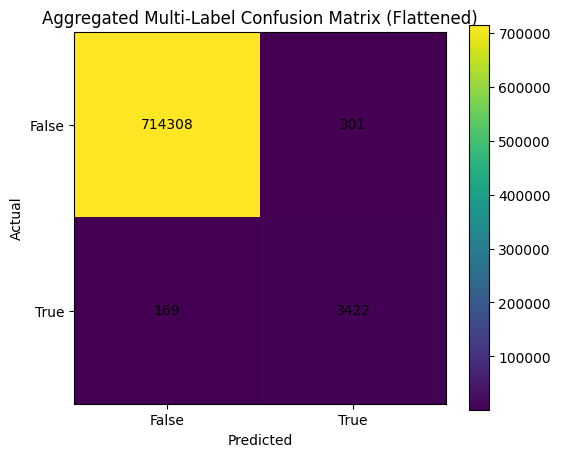

Aggregated confusion matrix saved as aggregated_confusion_matrix.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get Predictions
predictions_test = trainer.predict(test_dataset)
logits_test = predictions_test.predictions
labels_test = predictions_test.label_ids

best_threshold = eval_results['eval_Best Threshold']

# Convert logits → probabilities → predicted labels
probs = torch.sigmoid(torch.tensor(logits_test)).numpy()
y_pred_test = (probs > best_threshold).astype(int)
y_true_test = labels_test

# Flatten everything
y_true_flat = y_true_test.flatten()
y_pred_flat = y_pred_test.flatten()

# Compute confusion matrix (flattened, raw counts)
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])

# Replace numeric class names
xticks = ["False", "True"]
yticks = ["False", "True"]

# Plot aggregated confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Aggregated Multi-Label Confusion Matrix (Flattened)")
plt.colorbar()

plt.xticks([0, 1], xticks)
plt.yticks([0, 1], yticks)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")

os.makedirs("confusion_matrix", exist_ok=True)
plt.savefig("confusion_matrix/aggregated_confusion_matrix.png", bbox_inches='tight')
plt.show()

print("Aggregated confusion matrix saved as aggregated_confusion_matrix.png")


ROC / AUC Curve (Multi-Label)

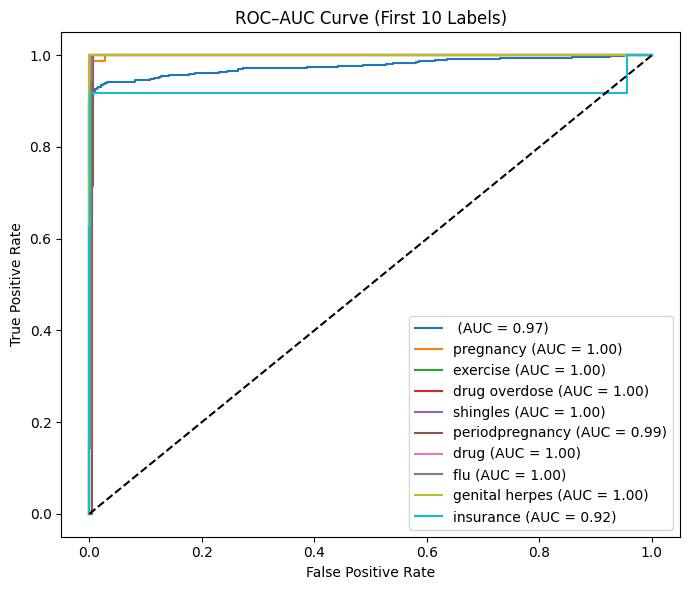

In [ ]:
from sklearn.metrics import roc_curve, auc
import torch # Import torch for sigmoid function

# Get predictions from the test dataset to calculate probabilities
predictions_test = trainer.predict(test_dataset)
logits = predictions_test.predictions

# Calculate probabilities using sigmoid on the logits
probs = torch.sigmoid(torch.tensor(logits)).cpu().numpy()

plt.figure(figsize=(7, 6))

for i, tag in enumerate(mlb.classes_[:10]):   # plot only first 10 to avoid crowding
    # Ensure test_labels is a numpy array
    fpr, tpr, _ = roc_curve(test_labels[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{tag} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve (First 10 Labels)")
plt.legend()
plt.tight_layout()
plt.show()


Comparison Graph: Train vs Test Metrics

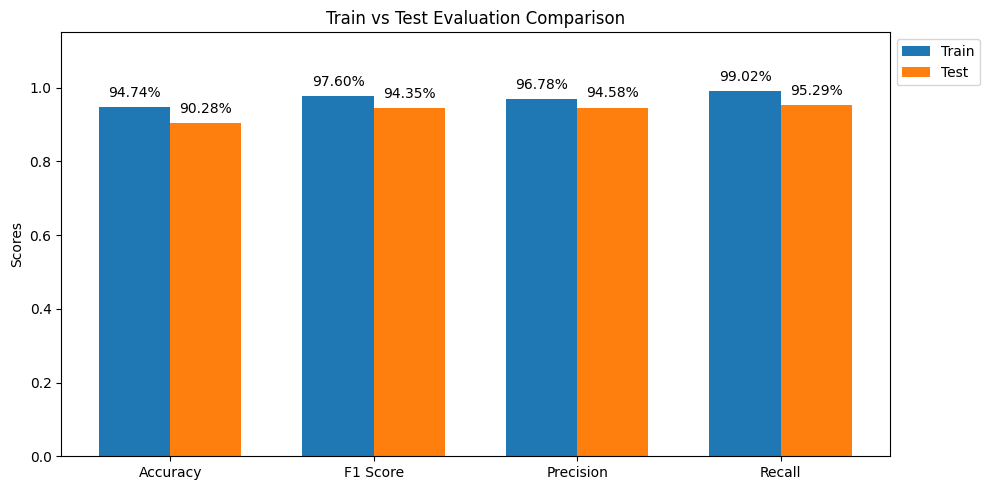

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Accuracy", "F1 Score", "Precision", "Recall"]

train_scores = [overall_accuracy, overall_f1, overall_precision, overall_recall]

test_scores = [
    eval_results["eval_Accuracy"],
    eval_results["eval_F1 Score"],
    eval_results["eval_Precision"],
    eval_results["eval_Recall"]
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
bars_train = plt.bar(x - width/2, train_scores, width, label="Train")
bars_test = plt.bar(x + width/2, test_scores, width, label="Test")

plt.xticks(x, metrics)
plt.ylabel("Scores")
plt.title("Train vs Test Evaluation Comparison")
plt.ylim(0, 1.15)

# move legend outside the bar chart
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.tight_layout()

# Add percentage labels
def add_labels(bars):
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.02,
            f"{h*100:.2f}%",
            ha='center', va='bottom', fontsize=10
        )

add_labels(bars_train)
add_labels(bars_test)

plt.show()


Performance Comparison Between This Work and Prior Research

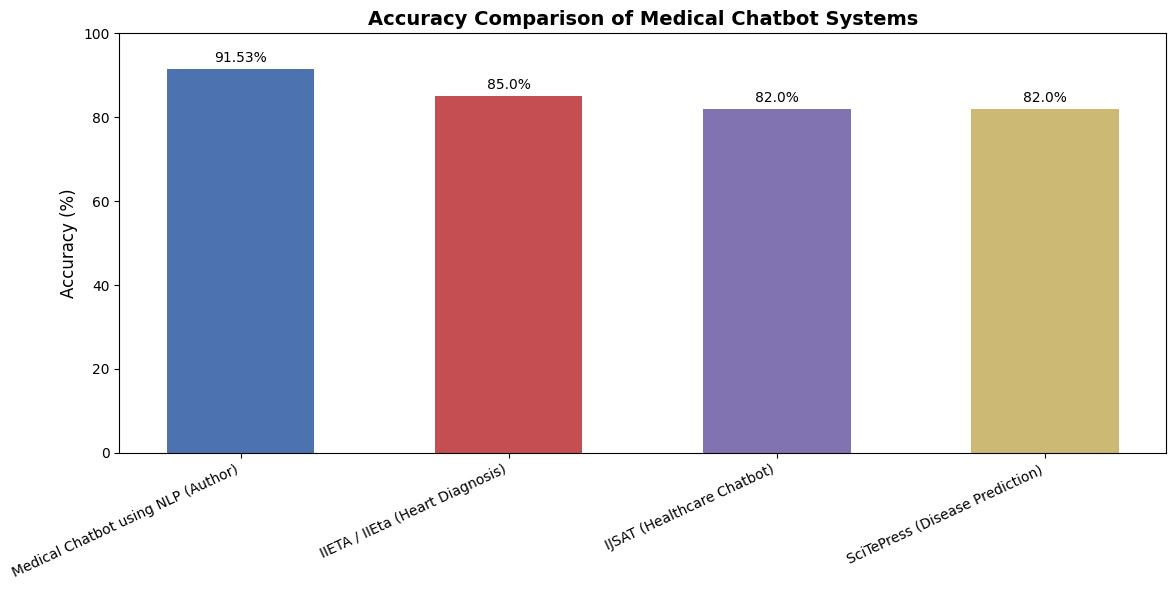

In [ ]:
# Labels for each project/paper
labels = [
    "Medical Chatbot using NLP (Author)",   # Your project
    "IIETA / IIEta (Heart Diagnosis)",
    "IJSAT (Healthcare Chatbot)",
    "SciTePress (Disease Prediction)"
]

# Accuracy values
accuracies = [91.53, 85, 82, 82]

# Color scheme with premium palette
colors = [
    "#4C72B0",  # Blue
    "#C44E52",  # Red
    "#8172B2",  # Purple
    "#CCB974"   # Gold
]

# Create plot layout
x = np.arange(len(labels))
plt.figure(figsize=(12, 6))

bars = plt.bar(x, accuracies, color=colors, width=0.55)

# Add title and axis label
plt.title("Accuracy Comparison of Medical Chatbot Systems", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)

# Rotate labels for clarity
plt.xticks(x, labels, rotation=25, ha='right', fontsize=10)

# Annotate values on each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"{height}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()

Plot Confidence Scores

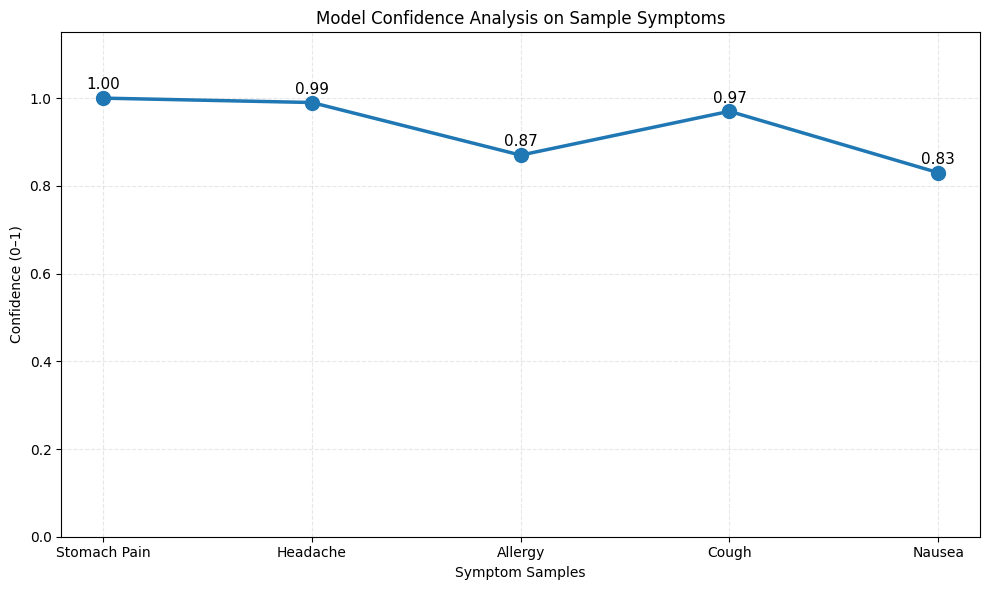

In [ ]:
import matplotlib.pyplot as plt

samples = ["Stomach Pain", "Headache", "Allergy", "Cough", "Nausea"]
confidences = [1.0, 0.99, 0.87, 0.97, 0.83]

plt.figure(figsize=(10,6))

# --- Smooth Line Plot with Nice Markers ---
plt.plot(samples, confidences, linewidth=2.5, marker='o', markersize=10)

# Add value labels near each point
for x, y in zip(samples, confidences):
    plt.text(x, y + 0.02, f"{y:.2f}", ha='center', fontsize=11)

plt.ylim(0, 1.15)
plt.xlabel("Symptom Samples")
plt.ylabel("Confidence (0–1)")
plt.title("Model Confidence Analysis on Sample Symptoms")

# Soft grid for aesthetics
plt.grid(linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Save and Reload BERT Model

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Saving the Model
model_save_path = "/content/drive/MyDrive/medical_bert_model"
label_map_path = "/content/drive/MyDrive/label_map_top50.json"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Reload for inference
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

with open(label_map_path, "r") as f:
    label_map = json.load(f)  # list of disease labels in order


Load Local LLM (Mistral via ctransformers)

In [ ]:
# Predict Tags Function
def predict_tags(text, threshold=0.5):
    """Run inference on text and return predicted tags with confidences."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    pred_indices = np.where(probs >= threshold)[0]
    results = [{"tag": label_map[idx], "confidence": float(probs[idx])} for idx in pred_indices]

    if len(results) == 0:  # fallback
        best_idx = probs.argmax()
        results = [{"tag": label_map[best_idx], "confidence": float(probs[best_idx])}]
    return results

In [ ]:
# Install and Load Mistral LLM
!pip install ctransformers

from ctransformers import AutoModelForCausalLM

llm = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.2-GGUF",
    model_file="mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=20  # set to 0 if CPU only
)
print("Models loaded successfully!")


In [ ]:
# Red Flag Symptoms Dictionary

RED_FLAG_SYMPTOMS = {
    "chest pain": "Possible cardiac emergency",
    "severe shortness of breath": "Possible respiratory emergency",
    "difficulty breathing": "Possible respiratory emergency",
    "can't breathe": "Possible respiratory emergency",
    "fainting": "Syncope or severe hypotension",
    "passed out": "Syncope or severe hypotension",
    "seizure": "Neurological emergency",
    "convulsion": "Neurological emergency",
    "uncontrolled bleeding": "Hemorrhage",
    "heavy bleeding": "Hemorrhage",
    "severe bleeding": "Hemorrhage",
    "sudden vision loss": "Stroke / Ophthalmic emergency",
    "confusion": "Possible stroke or metabolic emergency",
    "disoriented": "Possible stroke or metabolic emergency",
    "high fever with rash": "Infectious emergency",
    "stiff neck": "Possible meningitis",
    "severe abdominal pain": "Possible appendicitis or internal bleeding",
    "severe stomach pain": "Possible appendicitis or internal bleeding",
    "suicidal": "Mental health crisis",
    "want to die": "Mental health crisis",
    "kill myself": "Mental health crisis",
    "stroke": "Neurological emergency",
    "paralysis": "Neurological emergency",
    "slurred speech": "Possible stroke",
    "coughing blood": "Respiratory emergency",
    "vomiting blood": "Gastrointestinal emergency"
}

# Check Red Flags Function
def check_red_flags(text):
    """Return True + reason if red-flag symptom is detected."""
    lower_text = text.lower()
    for phrase, reason in RED_FLAG_SYMPTOMS.items():
        if phrase in lower_text:
            return True, reason
    return False, None


In [ ]:
# Predict Tags Function
def predict_tags(text, threshold=0.5):
    """Run inference on text and return predicted tags with confidences."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    pred_indices = np.where(probs >= threshold)[0]
    results = [{"tag": label_map[idx], "confidence": float(probs[idx])} for idx in pred_indices]

    if len(results) == 0:  # fallback
        best_idx = probs.argmax()
        results = [{"tag": label_map[best_idx], "confidence": float(probs[best_idx])}]
    return results

In [ ]:
# Generate Follow-up Questions (FIXED)
def generate_followup_questions(symptoms, n=3):
    """Generate short, medically relevant follow-up questions WITHOUT using patient names."""
    prompt = f"""You are a careful medical assistant.
The patient reports: "{symptoms}".

Generate exactly {n} short medical follow-up questions.
Each question must be under 10 words.
Use "you" or "your" - do not use any patient names, titles like Mr., Mrs., Dr., or words like "patient".

Example format:
- How long have you had these symptoms?
- What is your temperature?
- Are you taking any medication?

Generate {n} questions now:"""

    try:
        output = llm(prompt, max_new_tokens=150, temperature=0.2)

        # Parse and clean the output
        questions = [q.strip("-•1234567890. ") for q in output.split("\n") if q.strip()]

        # Filter out lines with names or non-question text
        cleaned_questions = []
        name_indicators = ["mr.", "mrs.", "ms.", "dr.", "miss", "patient", "mr ", "mrs ", "ms ", "dr "]

        for q in questions:
            q_lower = q.lower()
            # Only keep actual questions without name references
            if "?" in q and not any(indicator in q_lower for indicator in name_indicators):
                # Replace any remaining name references
                q = q.replace("the patient", "you")
                q = q.replace("Patient", "you")
                q = q.replace("patient", "you")
                cleaned_questions.append(q)

        # If we got enough good questions, return them
        if len(cleaned_questions) >= n:
            return cleaned_questions[:n]

        # Otherwise add fallback questions
        fallback_questions = [
            "How long have you had these symptoms?",
            "What is your temperature?",
            "Are you taking any medicines?",
            "Do you have any other symptoms?",
            "When did symptoms start?"
        ]

        # Combine cleaned questions with fallbacks to reach n questions
        while len(cleaned_questions) < n and fallback_questions:
            cleaned_questions.append(fallback_questions.pop(0))

        return cleaned_questions[:n]

    except Exception as e:
        print(f"Error generating questions: {e}")
        return [
            "How long have you had these symptoms?",
            "What is your temperature?",
            "Are you taking any medicines?"
        ]


In [ ]:
# Medical Chatbot Main Function

def medical_chatbot(user_message, followup_answers=None):
    """
    Hybrid Medical Chatbot:
    1. Check for emergency (red flags)
    2. Generate follow-up questions
    3. Predict disease using BERT
    4. Generate empathetic advice using LLM
    """

    # Stage 1: Initial Red-Flag Check
    flagged, reason = check_red_flags(user_message)
    if flagged:
        return {
            "status": "emergency",
            "alert": f"⚠️ Emergency Warning: {reason}",
            "response": (
                f"You mentioned symptoms indicating '{reason}'. "
                "This may require **immediate medical attention**.\n\n"
                "Go to the nearest hospital emergency room.\n"
                "Do not delay seeking professional medical care.\n"
                "🚑 Dial: 102 (Ambulance)"
            )
        }

    # Stage 2: Ask Follow-Up Questions
    if followup_answers is None:
        return {
            "status": "need_followup",
            "questions": generate_followup_questions(user_message)
        }

    # Stage 3: Check Red Flags in Answers
    for q, a in followup_answers.items():
        flagged, reason = check_red_flags(a)
        if flagged:
            return {
                "status": "emergency",
                "alert": f"⚠️ Emergency Warning: {reason}",
                "response": (
                    f"In your answer '{a}', we detected symptoms indicating '{reason}'. "
                    "This may require **urgent medical attention**.\n\n"
                    "Go to the nearest hospital emergency room.\n"
                    "Do not delay seeking professional medical care.\n"
                    "🚑 Dial: 102 (Ambulance)"
                )
            }

    # Stage 4: Predict Disease(s) using BERT
    qa_str = " ".join([f"{q} {a}" for q, a in followup_answers.items()])
    full_input = f"User: {user_message}. Follow-ups: {qa_str}"
    preds = predict_tags(full_input)
    disease, confidence = preds[0]["tag"], preds[0]["confidence"]

    # Stage 5: Generate Empathetic Response using LLM
    explanation_prompt = f"""User symptoms: {user_message}
Follow-up answers: {qa_str}
Predicted condition: {disease} (confidence {confidence:.2f})

Write a short, empathetic medical response (3-5 sentences):
- Explain briefly why {disease} fits these symptoms.
- Suggest safe next steps (home care, when to see doctor).
- End with: "⚠️ This is not medical advice. Consult a healthcare professional for proper diagnosis. Seek emergency care if symptoms worsen."

Do not use any patient names."""

    explanation = llm(explanation_prompt, max_new_tokens=250, temperature=0.3)

    return {
        "status": "complete",
        "disease": disease,
        "confidence": confidence,
        "response": explanation.strip()
    }

In [ ]:
# Example Run
msg = "I have headache and mild fever since yesterday"
resp = medical_chatbot(msg)

if resp["status"] == "need_followup":
    print("🤖 Follow-up Questions:")
    for i, q in enumerate(resp["questions"], 1):
        print(f"{i}. {q}")

    # Simulated user answers
    answers = {
        resp["questions"][0]: "Yes, it started two days ago",
        resp["questions"][1]: "No vomiting",
        resp["questions"][2]: "Yes, slight body pain"
    }

    final_resp = medical_chatbot(msg, answers)
    print("\n Predicted Condition:", final_resp["disease"])
    print(" Confidence:", round(final_resp["confidence"], 2))
    print("\n💬 Chatbot Response:\n", final_resp["response"])

elif resp["status"] == "emergency":
    print(resp["alert"])
    print(resp["response"])
else:
    print(resp["response"])

In [ ]:
# Save BERT Model
from transformers import BertForSequenceClassification, BertTokenizer

model_dir = "/content/drive/MyDrive/medical_bert_model_final"

model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

print(f"BERT model + tokenizer saved at {model_dir}")

In [ ]:
#  Check Mistral Cache

!ls -lh /root/.cache/ctransformers/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/


# Download Mistral Model Manually
!mkdir -p /root/.cache/ctransformers/TheBloke/Mistral-7B-Instruct-v0.2-GGUF
!wget -c https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf \
     -O /root/.cache/ctransformers/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/mistral-7b-instruct-v0.2.Q4_K_M.gguf


# Load LLM from Local Path
from ctransformers import AutoModelForCausalLM

llm = AutoModelForCausalLM.from_pretrained(
    "/root/.cache/ctransformers/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=20
)
print("LLM loaded successfully from local path!")

In [ ]:
# Complete Chat System

import torch
from transformers import BertTokenizer, BertForSequenceClassification
import json
import numpy as np
from ctransformers import AutoModelForCausalLM

# Load Models
bert_model_path = "/content/drive/MyDrive/medical_bert_model_final"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained(bert_model_path)

# Load label map
with open("/content/drive/MyDrive/label_map_top50.json") as f:
    label_map = json.load(f)

# Load LLM
llm = AutoModelForCausalLM.from_pretrained(
    "/root/.cache/ctransformers/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=20
)


In [ ]:
# Helper Functions
def get_followup_questions(symptom_input):
    """Ask LLM to generate short, targeted follow-up questions WITHOUT patient names."""
    prompt = f"""You are a careful medical assistant.
The user said: "{symptom_input}".

Generate exactly 3 short and relevant medical follow-up questions.
Each question must be under 8 words.
Use "you" or "your" - do not use any patient names, titles, or the word "patient".

Example format:
1. How long have you had symptoms?
2. What is your temperature?
3. Are you taking medication?

Generate 3 questions now:"""

    try:
        response = llm(prompt, max_new_tokens=150, temperature=0.2)

        # Clean up the response
        lines = [line.strip() for line in response.split("\n") if line.strip()]

        # Filter questions and remove name references
        cleaned = []
        name_indicators = ["mr.", "mrs.", "ms.", "dr.", "patient", "miss", "mr ", "mrs ", "ms ", "dr "]

        for line in lines:
            line_lower = line.lower()
            if "?" in line and not any(name in line_lower for name in name_indicators):
                # Clean up numbering and formatting
                line = line.strip("-•1234567890. ")
                # Remove any remaining patient references
                line = line.replace("the patient", "you")
                line = line.replace("Patient", "you")
                cleaned.append(line)

        # Return cleaned questions or fallback
        if len(cleaned) >= 3:
            return "\n".join(cleaned[:3])
        else:
            # Use fallback if not enough good questions
            fallback = [
                "How long have you had these symptoms?",
                "What is your temperature?",
                "Are you taking any medicines?"
            ]
            # Mix cleaned with fallback
            while len(cleaned) < 3:
                cleaned.append(fallback[len(cleaned)])
            return "\n".join(cleaned[:3])

    except Exception as e:
        print(f"Error generating questions: {e}")
        return """How long have you had these symptoms?
What is your temperature?
Are you taking any medicines?"""

In [ ]:
def predict_disease(symptom_input):
    """Use BERT model to predict the most likely disease."""
    inputs = tokenizer(symptom_input, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        logits = bert_model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    top_idx = np.argmax(probs)
    predicted_label = label_map[top_idx]
    confidence = float(probs[top_idx])
    return predicted_label, confidence

In [ ]:
def generate_explanation(symptoms, diagnosis, confidence):
    """Use LLM to create an explanation and care advice."""
    prompt = f"""You are a medical assistant. A user reports these symptoms: {symptoms}

The system predicted: {diagnosis} (confidence: {confidence:.2f})

Write a helpful response with 4 parts:

Part 1: Briefly explain how {diagnosis} matches these symptoms (1-2 sentences)

Part 2: Mention 2 possible causes of {diagnosis}

Part 3: Give 3 self-care tips for managing {diagnosis}

Part 4: End with: "⚠️ This is not medical advice. Please consult a healthcare professional for proper diagnosis."

Write naturally and be empathetic. Start writing now:"""

    try:
        response = llm(prompt, max_new_tokens=500, temperature=0.4)

        # Clean and validate response
        response = response.strip()

        # Filter out meta-instructions
        unwanted_phrases = [
            "use gender neutral",
            "gender-neutral language",
            "avoid assuming",
            "use inclusive language"
        ]

        response_lower = response.lower()
        if any(phrase in response_lower for phrase in unwanted_phrases):
            # If we got a meta-instruction instead of actual content, use fallback
            print("⚠️ LLM returned meta-instruction, using fallback response")
            response = f"""Based on your symptoms, {diagnosis} appears likely with a confidence of {confidence:.2f}.

Your symptoms align with this condition, which commonly develops due to viral infection or environmental factors.

Self-care recommendations:
- Get plenty of rest and sleep
- Stay well-hydrated with water and clear fluids
- Monitor symptoms and seek medical help if they worsen

⚠️ This is not medical advice. Please consult a healthcare professional for proper diagnosis."""

        # Ensure disclaimer is present
        if "⚠️" not in response and "not medical advice" not in response.lower():
            response += "\n\n⚠️ This is not medical advice. Please consult a healthcare professional for proper diagnosis."

        return response

    except Exception as e:
        print(f"Error generating explanation: {e}")
        return f"""Based on your symptoms, {diagnosis} seems likely (confidence: {confidence:.2f}).

This condition typically develops due to infection, stress, or environmental factors. Your symptoms are consistent with this diagnosis.

Self-care tips:
- Rest and maintain proper hydration
- Monitor your symptoms closely
- Seek medical attention if symptoms persist or worsen

⚠️ This is not medical advice. Please consult a healthcare professional for proper diagnosis."""


# Chat Loop Example
def medical_chatbot():
    print("🤖 Medical Assistant: Hello! What symptoms are you experiencing today?")
    user_input = input("🧍 You: ")

    # Step 1: Ask follow-up questions
    print("\n🤖 Generating follow-up questions...")
    questions = get_followup_questions(user_input)
    print(questions)

    # Step 2: Collect answers
    followup_answers = input("\n🧍 Please answer briefly to the above questions: ")

    # Combine input and follow-up info
    combined_input = f"{user_input}. {followup_answers}"

    # Step 3: Predict disease
    diagnosis, confidence = predict_disease(combined_input)

    # Step 4: Generate explanation
    print("\n🤖 Generating explanation and care advice...")
    explanation = generate_explanation(combined_input, diagnosis, confidence)

    # Step 5: Display results
    print(f"\n Predicted Disease: {diagnosis}")
    print(f" Confidence: {confidence:.2f}")
    print(f"\n💬 Explanation & Advice:\n{explanation}")


#  Run Chat
medical_chatbot()

In [ ]:
# Save Trained Model
trainer.save_model("/content/bert_medical_chatbot_model")
print("Model saved successfully!")


# Test Mistral LLM
prompt = "You are a helpful medical assistant. A patient says they have a headache and fever. What could be the possible reasons?"
response = llm(prompt, max_new_tokens=200)
print(response)


# Save BERT for Deployment
import torch

# Save the model and tokenizer
bert_model.save_pretrained("/content/final_medical_chatbot/bert_classifier")
tokenizer.save_pretrained("/content/final_medical_chatbot/bert_classifier")

print("BERT classifier saved successfully!")


# Save LLM Path Reference
llm_path = "/content/mistral-7b-instruct-v0.2.Q4_K_M.gguf"

# Save the path reference
import os

os.makedirs("/content/final_medical_chatbot", exist_ok=True)
with open("/content/final_medical_chatbot/llm_path.txt", "w") as f:
    f.write(llm_path)

print("LLM path saved successfully!")

In [ ]:
# Zip Model Files
import shutil

shutil.make_archive("/content/final_medical_chatbot", "zip", "/content/final_medical_chatbot")

print("Model files zipped and ready to download!")


# Copy to Google Drive
!cp -r /content/final_medical_chatbot /content/drive/MyDrive/final_medical_chatbot
print("Files copied to Google Drive!")


# Download Mistral Model
!wget https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf


# Zip Mistral Model
!zip -r mistral_model.zip mistral-7b-instruct-v0.2.Q4_K_M.gguf


# Download Zipped Model
from google.colab import files
files.download("mistral_model.zip")
print("Download started!")